In the next cell we import the necessary packages.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import plotly.graph_objects as go
from pickle import NONE

**Global**

This class aims at being more efficient and make the code easier to understand for the next questions.
Here we have created a class which:
- Gather Fred and Goyal Welch data in one data frame that is then cut into signals and labels
- Create random features (random features are not called in the init function as we only use this function in the first part of the assignement)
- Create train and test data usable for both questions of the assignement

In [ ]:
class FredAndGoyalData:
  def __init__(self):
    self.read_data()

  def read_data(self):
    import os
    from google.colab import drive
    import pandas as pd
    drive.mount('/content/gdrive')
    folder = '/content/gdrive/MyDrive'
    fred_data = pd.read_csv(os.path.join(folder,'FRED_MD.csv'), index_col=0).iloc[1:, :]
    fred_data.index = pd.to_datetime(fred_data.index)
    goyal_welch_data = pd.read_csv(os.path.join(folder,'GoyalWelchPredictorData2022Monthly.csv'), index_col=0)
    goyal_welch_data.index = pd.to_datetime(goyal_welch_data.index, format='%Y%m')

    for column in fred_data.columns:
      fred_data[column] = [float(str(x).replace(',', '')) for x in fred_data[column]]
    for column in goyal_welch_data.columns:
        goyal_welch_data[column] = [float(str(x).replace(',', '')) for x in goyal_welch_data[column]]

    global_data = pd.concat([goyal_welch_data,fred_data],axis=1)
    self.global_data = global_data
    self.get_cleaned_data()
    self.select_signals()

  def get_cleaned_data(self):
    self.global_data['returns'] = ((self.global_data.Index)/ self.global_data.Index.shift(1) - 1).fillna(0)
    self.global_data['excess_returns'] = self.global_data.returns - self.global_data.Rfree
    self.cleaned_data = self.global_data.loc['1975':'2022'].fillna(0)

  def normalize(self,
                data: np.ndarray,
                ready_normalization: dict = None,
                use_std: bool = False):
    """

    """
    if ready_normalization is None:
        data_std = data.std(0)
        if use_std:
          data = data / data_std
        else:
          data_max = np.max(data, axis=0)
          data_min = np.min(data, axis=0)
    else:
        data_std = ready_normalization['std']
        if use_std:
          data = data / data_std
        else:
          data_max = ready_normalization['max']
          data_min = ready_normalization['min']

    data = data - data_min
    data = data/(data_max - data_min)
    data = data - 0.5

    normalization = {'std': data_std,
                      'max': data_max,
                      'min': data_min}
    return data,normalization

  def select_signals(self):
    signal_columns = ['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'CRSP_SPvw', 'CRSP_SPvwx', 'returns', 'excess_returns', 'RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS', 'HWI', 'HWIURATIO', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'ACOGNO', 'AMDMNOx', 'ANDENOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx', 'M1SL', 'M2SL', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'S&P 500', 'S&P: indust', 'S&P div yield', 'S&P PE ratio', 'FEDFUNDS', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'TWEXAFEGSMTHx', 'EXSZUSx', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx', 'WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'OILPRICEx', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'CES0600000008', 'CES2000000008', 'CES3000000008', 'UMCSENTx', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VIXCLSx']
    cleaned_data = self.cleaned_data
    data_for_signals = cleaned_data[signal_columns].shift(1).fillna(0)
    labels = cleaned_data.excess_returns.values.reshape(-1, 1)
    signals = data_for_signals.values
    self.signals = signals

  def get_random_features(self, omega, act_function):
      signals, normalization  = self.normalize(self.signals)
      comb = signals @ omega.T
      if act_function == 'sincos':
          ins_sin = np.sqrt(2) * np.sin(comb)
          ins_cos = np.sqrt(2) * np.cos(comb)
          random_features = np.append(ins_sin, ins_cos, axis=1)

      elif act_function == 'relu':
          random_features = np.maximum(0,comb)

      elif act_function == 'sigmoid':
          random_features = 1 / (1 + np.exp(-(comb)))

      elif act_function == 'tanh':
          random_features = np.tanh(comb)
      return random_features

  def get_train_and_test_data(self, random_ft=None,labels=None, random_feat=False,normalize_raw_data=True, cheat_and_use_future_data=False):
    if random_feat:
      signals = random_ft
    else:
      signals = self.signals
      labels = self.cleaned_data.excess_returns.values.reshape(-1, 1)
    split = int(signals.shape[0] / 2)
    train_labels = labels[:split]
    test_labels = labels[split:]
    test_dates = self.cleaned_data.excess_returns.index[split:]

    if normalize_raw_data:
        signals[:split, :], normalization = self.normalize(signals[:split]) #normalization train set
        if cheat_and_use_future_data:
          signals[split:, :] = self.normalize(signals[split:, :])[0] #normalisation test test
        else:
          signals[split:, :] = self.normalize(signals[split:, :],
                                        ready_normalization=normalization)[0] #normalisation test test
    train_data = signals[:split, :]
    test_data = signals[split:, :]
    return train_data, test_data, train_labels, test_labels, test_dates

  def sharpe_ratio(x):
    return np.round(np.sqrt(12) * x.mean(0) / x.std(0), 2)

In the next cell, we define the function that performs the ridge regression on
the signals. We distinguish between two scenarios, one where the number of observations is higher than the number of signals and one where the number of observations is lower than the number of signals.

In [ ]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means # this is \mu

        # now we build [(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}] * \mu
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)

        tmp = eigenvectors.T @ signals # U.T @ S
        betas = tmp.T @ intermed # (S.T @ U) @ [(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}] * \mu
    predictions = future_signals @ betas
    return betas, predictions

In [ ]:
def performance_metrics_of_regression(labels: np.ndarray,
                                      predictions: np.ndarray) -> tuple:
    """
    Compute standard performance metrics for regression: mse and Rsquared
    """
    mse = ((predictions - labels) ** 2).mean()
    r2 = 1 - mse / (labels ** 2).mean()

    return mse, r2

**Partie 2.1**

In the next cell, we call the FredAndGoyalData class in which init calls the read_data function which in turn calls the get_cleaned_data and select_signals functions. Finally we just have to invoke the get_train_and_test_data.

In [ ]:
global_data_RF = FredAndGoyalData()

Mounted at /content/gdrive


<ipython-input-2-5e54f668a483>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.global_data['returns'] = ((self.global_data.Index)/ self.global_data.Index.shift(1) - 1).fillna(0)
<ipython-input-2-5e54f668a483>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.global_data['excess_returns'] = self.global_data.returns - self.global_data.Rfree


Finally we define a list of the ridge penalties we will use in the ridge regressions.

In [ ]:
shrinkage_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

Here we have thus chosen 4 different activation functions to build our random features:
- Sincos
- Relu
- sigmoid
- tanh

The objective is to analyze those different activation functions with different shrinkage and scale.
We compute all possible combinations of those three variables in order ot find the best possible performance

RF_list is a numpy array of all random features for each unique combination of the three variables. We will then compute a ridge regression on every set of random features

In [ ]:
act_func = ['sincos','relu', 'sigmoid', 'tanh']
d = 149
P = 30000
sc_list = [0.0001,0.01,0.1,1.,10]

np.random.seed(42) #ajout random seed for reproductibility
o1 = np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)

rf_list = []
spec_list = []
for scale in sc_list:
    omega = scale * o1
    for func in act_func:
        rf_list.append(global_data_RF.get_random_features(omega,func))
        for i in shrinkage_list:
            spec_list.append([scale,func,i])

In [ ]:
index_list = []
for i in range(len(rf_list)*len(shrinkage_list)):
    index_list.append(i+1)
rf_perf_data = pd.DataFrame(0,index = index_list, columns = ['Activation_Function', 'Ridge_Penalty', 'Scale', 'Sharpe_Ratio', 'MSE'])

We then use the get_train_and_test data function from the class and as we are in the random features case we have to send our rf_list and labels. We don't normalize as we have already normalized before in the get_random features function

In [ ]:
labels = global_data_RF.cleaned_data.excess_returns
beta_estimates = []
preds = []
for rf in range(len(rf_list)):

    X_train, X_test, y_train, y_test, test_dates = global_data_RF.get_train_and_test_data(rf_list[rf], labels, random_feat=True, normalize_raw_data=False)

    beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=X_train,
                                                                  labels=np.array(y_train),
                                                                  future_signals=X_test,
                                                                  shrinkage_list=shrinkage_list)
    beta_estimates.append(beta_estimate_using_train_sample)
    preds.append(oos_predictions)

Based on the predictions, we can calculate the market timing returns in the next cell.

In [ ]:
market_timing_returns = [oos_predictions * np.array(y_test).reshape(-1, 1) for oos_predictions in preds]

In this cell, we compute the sharpe ratios of the predictions for each model and the peformance metrics of the regressions.

In [ ]:
for i in range(len(rf_perf_data)):
    rf_perf_data.iloc[i,0] = spec_list[i][1]
    rf_perf_data.iloc[i,1] = spec_list[i][2]
    rf_perf_data.iloc[i,2] = spec_list[i][0]
    rf_perf_data.iloc[i,3] = FredAndGoyalData.sharpe_ratio(np.array(market_timing_returns[int(np.floor(i/10))][:,int(i%10)]).reshape(-1,1))
    rf_perf_data.iloc[i,4] = performance_metrics_of_regression(np.array(y_test).reshape(-1, 1),preds[int(np.floor(i/10))][:,int(i%10)])[0]

Finally we plot the sharpe ratio (color scale) against the activation function (X axis), the ridge penalty (Y axis) and the scale (Z axis). We can observe that the models that achieve the best sharpe ratios are the ones with tanh activation functions, ridge penalties below 0.1 and scales between 0.1 and 1.

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=rf_perf_data['Activation_Function'],  #Learning rate on the X axis
    y=rf_perf_data['Ridge_Penalty'],  #Depth on the Y axis
    z=rf_perf_data['Scale'],  #Decay on the Z axis
    mode='markers',
    marker=dict(
        size=5,
        color=rf_perf_data['Sharpe_Ratio'],  #Color scale for the sharpe ratio
        colorscale='Reds',  #Color
        colorbar=dict(title='Sharpe Ratio'),  #Color legend
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Activation Function', type='category', autorange=True),
        yaxis=dict(title='Ridge Penalty', type='log', autorange=True),
        zaxis=dict(title='Scale', type='log', autorange=True),
    )
)


fig.show()


In [ ]:
mean_sharpe_by_scale = rf_perf_data.groupby('Scale')['Sharpe_Ratio'].mean().round(2)
mean_sharpe_by_scale.name = 'Average Sharpe Ratio'
mean_sharpe_by_scale

Scale
0.0001     0.26
0.0100     0.27
0.1000     0.25
1.0000     0.26
10.0000    0.18
Name: Average Sharpe Ratio, dtype: float64

In [ ]:
mean_sharpe_by_penalty = rf_perf_data.groupby('Ridge_Penalty')['Sharpe_Ratio'].mean().round(2)
mean_sharpe_by_penalty.name = 'Average Sharpe Ratio'
mean_sharpe_by_penalty

Ridge_Penalty
0.000001       0.24
0.000010       0.24
0.000100       0.23
0.001000       0.23
0.010000       0.26
0.100000       0.27
1.000000       0.26
10.000000      0.25
100.000000     0.25
1000.000000    0.24
Name: Average Sharpe Ratio, dtype: float64

In [ ]:
mean_sharpe_by_function = rf_perf_data.groupby('Activation_Function')['Sharpe_Ratio'].mean().round(2)
mean_sharpe_by_function.name = 'Average Sharpe Ratio'
mean_sharpe_by_function

Activation_Function
relu       0.30
sigmoid    0.29
sincos     0.11
tanh       0.30
Name: Average Sharpe Ratio, dtype: float64

Conclusion:
- Scale has a significant effect on the sharpe ratio of timed returns. Value of the scale must be low (<=1)
- The ridge penalty has a small effect on the sharpe ratio of timed returns. Mean sharpe are all between 0.2395 and 0.266. Best performance when 0.01<=z<=10
- The activation function has the most significant impact on the sharpe ratio. The Sincos function is very bad compared to the other functions.

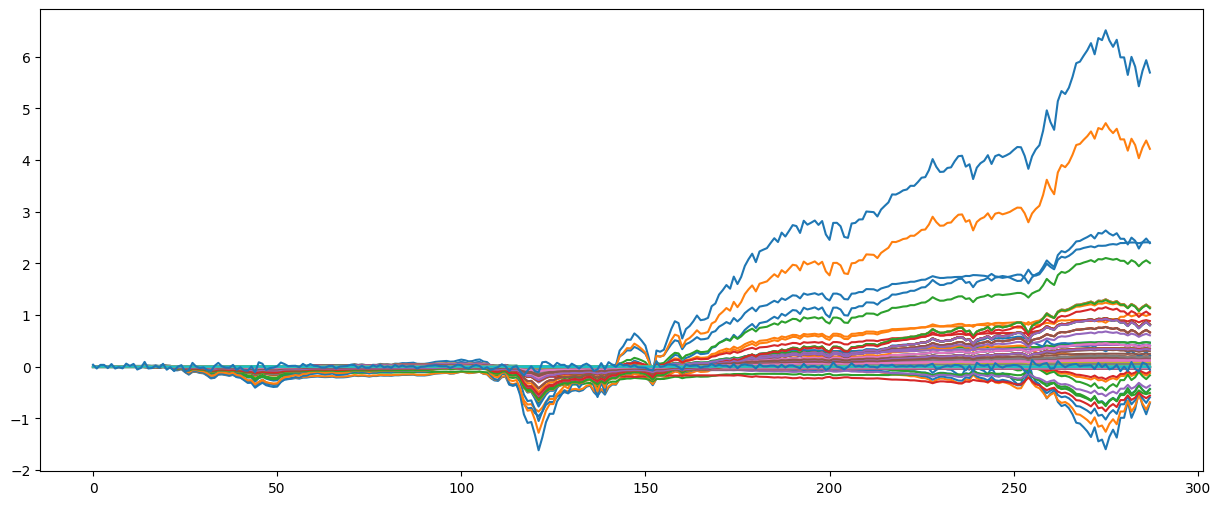

In [ ]:
plt.figure(figsize = (15,6))
for i in range(len(market_timing_returns)):
    for y in range(10):
        plt.plot(market_timing_returns[i][:,y].cumsum(), label = rf_perf_data.iloc[y+(10*i),3])
plt.plot(np.array(y_test), label = FredAndGoyalData.sharpe_ratio(np.array(y_test).reshape(-1,1)))
plt.show()

**Part 2.2:**

We first define a class that will allow us to custom our multi-layer perceptron. Indeed, we will be able to adjust the following attributes of our neural network depending on its performance: the depth, the width, the learning rate, and the decay.
Thus we decided to keep the initialization and random seed the same in the further experiments.

In [ ]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers):
        super(FlexibleMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])

            # LeCun initialization
            nn.init.normal_(layer.weight, mean=0.0, std=np.sqrt(1 / layers[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=np.sqrt(1 / layers[i]))

            self.layers.append(layer)
            # Add ReLU activation after each layer except the last
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                # Placeholder for the last layer's activation
                self.activations.append(nn.Identity())

    def forward(self, x, return_last_hidden=False):
        last_hidden = None

        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))
            last_hidden = x  # Update last_hidden at each hidden layer

        # Apply the last layer without ReLU (or Identity for the placeholder)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x

    def set_seed(seed_value=42):
      """Set seed for reproducibility."""
      np.random.seed(seed_value)  # Set NumPy seed
      torch.manual_seed(seed_value)  # Set PyTorch seed
      random.seed(seed_value)  # Set Python random seed

      # If you are using CUDA:
      if torch.cuda.is_available():
          torch.cuda.manual_seed(seed_value)
          torch.cuda.manual_seed_all(seed_value)  # For multi-GPU
          torch.backends.cudnn.deterministic = True
          torch.backends.cudnn.benchmark = False

We now define a function that will help us train and find the right model. The performance of the model will be assessed through the loss value.

In [ ]:
def train_model(num_epochs: int,
                train_loader: DataLoader,
                criterion,
                optimizer,
                model):
  # Training loop
  for epoch in range(num_epochs):
      for inputs, targets in train_loader:
          # Forward pass
          outputs = model(inputs) #input à l'objet qui donne output
          loss = criterion(outputs, targets) #criterion = loss function

          # Backward and optimize
          optimizer.zero_grad() # kill old gradients
          loss.backward() # compute new gradients
          optimizer.step() # perform the step of gradient descent

      if (epoch+1) % 20 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

**Training Neural Networks**

We then start training our neural network:

In [ ]:
global_data_NN = FredAndGoyalData() #init call la fonction read data qui call clean return et signals puis il suffit d'invoquer la fonction train et test
X_train, X_test, y_train, y_test, test_dates = global_data_NN.get_train_and_test_data()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<ipython-input-2-5e54f668a483>:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-2-5e54f668a483>:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Build deep neural networks in Pytorch and study the role of depth, learning rate, and weight decay.

Two possibilities:

- Simple = Plot performance (SR) as a function of a hyperparameter. The others do not move.

- Complex: Create a performance Landscape of SR as a function of depth, weights decay and LR.

In [ ]:
# Initialize the deep neural network model
list_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
list_depth = list(range(1, 11))
list_decay = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
width = 64

# Initialisation du dictionnaire pour stocker les modèles et leurs spécifications
model_specs = {}

model_idx = 0
for lr in list_lr:
    for depth in list_depth:
        for decay in list_decay:
            # Créer le modèle avec la spécification donnée
            model = FlexibleMLP([X_train.shape[1]] + [width] * depth + [1])

            # Stocker le modèle et ses spécifications dans le dictionnaire
            model_specs[model_idx] = {
                "model": model,
                "lr": lr,
                "depth": depth,
                "decay": decay,
                # Le Sharpe Ratio sera ajouté plus tard
            }

            # Préparation pour l'entrainement du modèle, ajustements similaires à ce que vous avez
            FlexibleMLP.set_seed(42)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

            train_model(num_epochs=200, train_loader=train_loader, criterion=criterion, optimizer=optimizer, model=model)

            model_idx += 1


Epoch [20/200], Loss: 0.0029
Epoch [40/200], Loss: 0.0025
Epoch [60/200], Loss: 0.0023
Epoch [80/200], Loss: 0.0022
Epoch [100/200], Loss: 0.0021
Epoch [120/200], Loss: 0.0020
Epoch [140/200], Loss: 0.0019
Epoch [160/200], Loss: 0.0018
Epoch [180/200], Loss: 0.0018
Epoch [200/200], Loss: 0.0017
Epoch [20/200], Loss: 0.0032
Epoch [40/200], Loss: 0.0028
Epoch [60/200], Loss: 0.0025
Epoch [80/200], Loss: 0.0023
Epoch [100/200], Loss: 0.0022
Epoch [120/200], Loss: 0.0022
Epoch [140/200], Loss: 0.0021
Epoch [160/200], Loss: 0.0021
Epoch [180/200], Loss: 0.0021
Epoch [200/200], Loss: 0.0021
Epoch [20/200], Loss: 0.0033
Epoch [40/200], Loss: 0.0028
Epoch [60/200], Loss: 0.0026
Epoch [80/200], Loss: 0.0025
Epoch [100/200], Loss: 0.0024
Epoch [120/200], Loss: 0.0023
Epoch [140/200], Loss: 0.0023
Epoch [160/200], Loss: 0.0023
Epoch [180/200], Loss: 0.0023
Epoch [200/200], Loss: 0.0023
Epoch [20/200], Loss: 0.0039
Epoch [40/200], Loss: 0.0031
Epoch [60/200], Loss: 0.0029
Epoch [80/200], Loss: 0.0

We build an evaluation function to evaluate appropriately the performance of our neural network.

In [ ]:
# Ensure the model is in evaluation mode
# Function to get predictions
def get_predictions(loader, model):
    model.eval()
    targets = [] #test target
    predictions = []

    with torch.no_grad(): #interrompre les gradients
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

Then we compute the plot of all of the NN compared to the index. We can see that some over perform the index and others seems to have learn the exact opposite of the index variation which can be surprising at first.

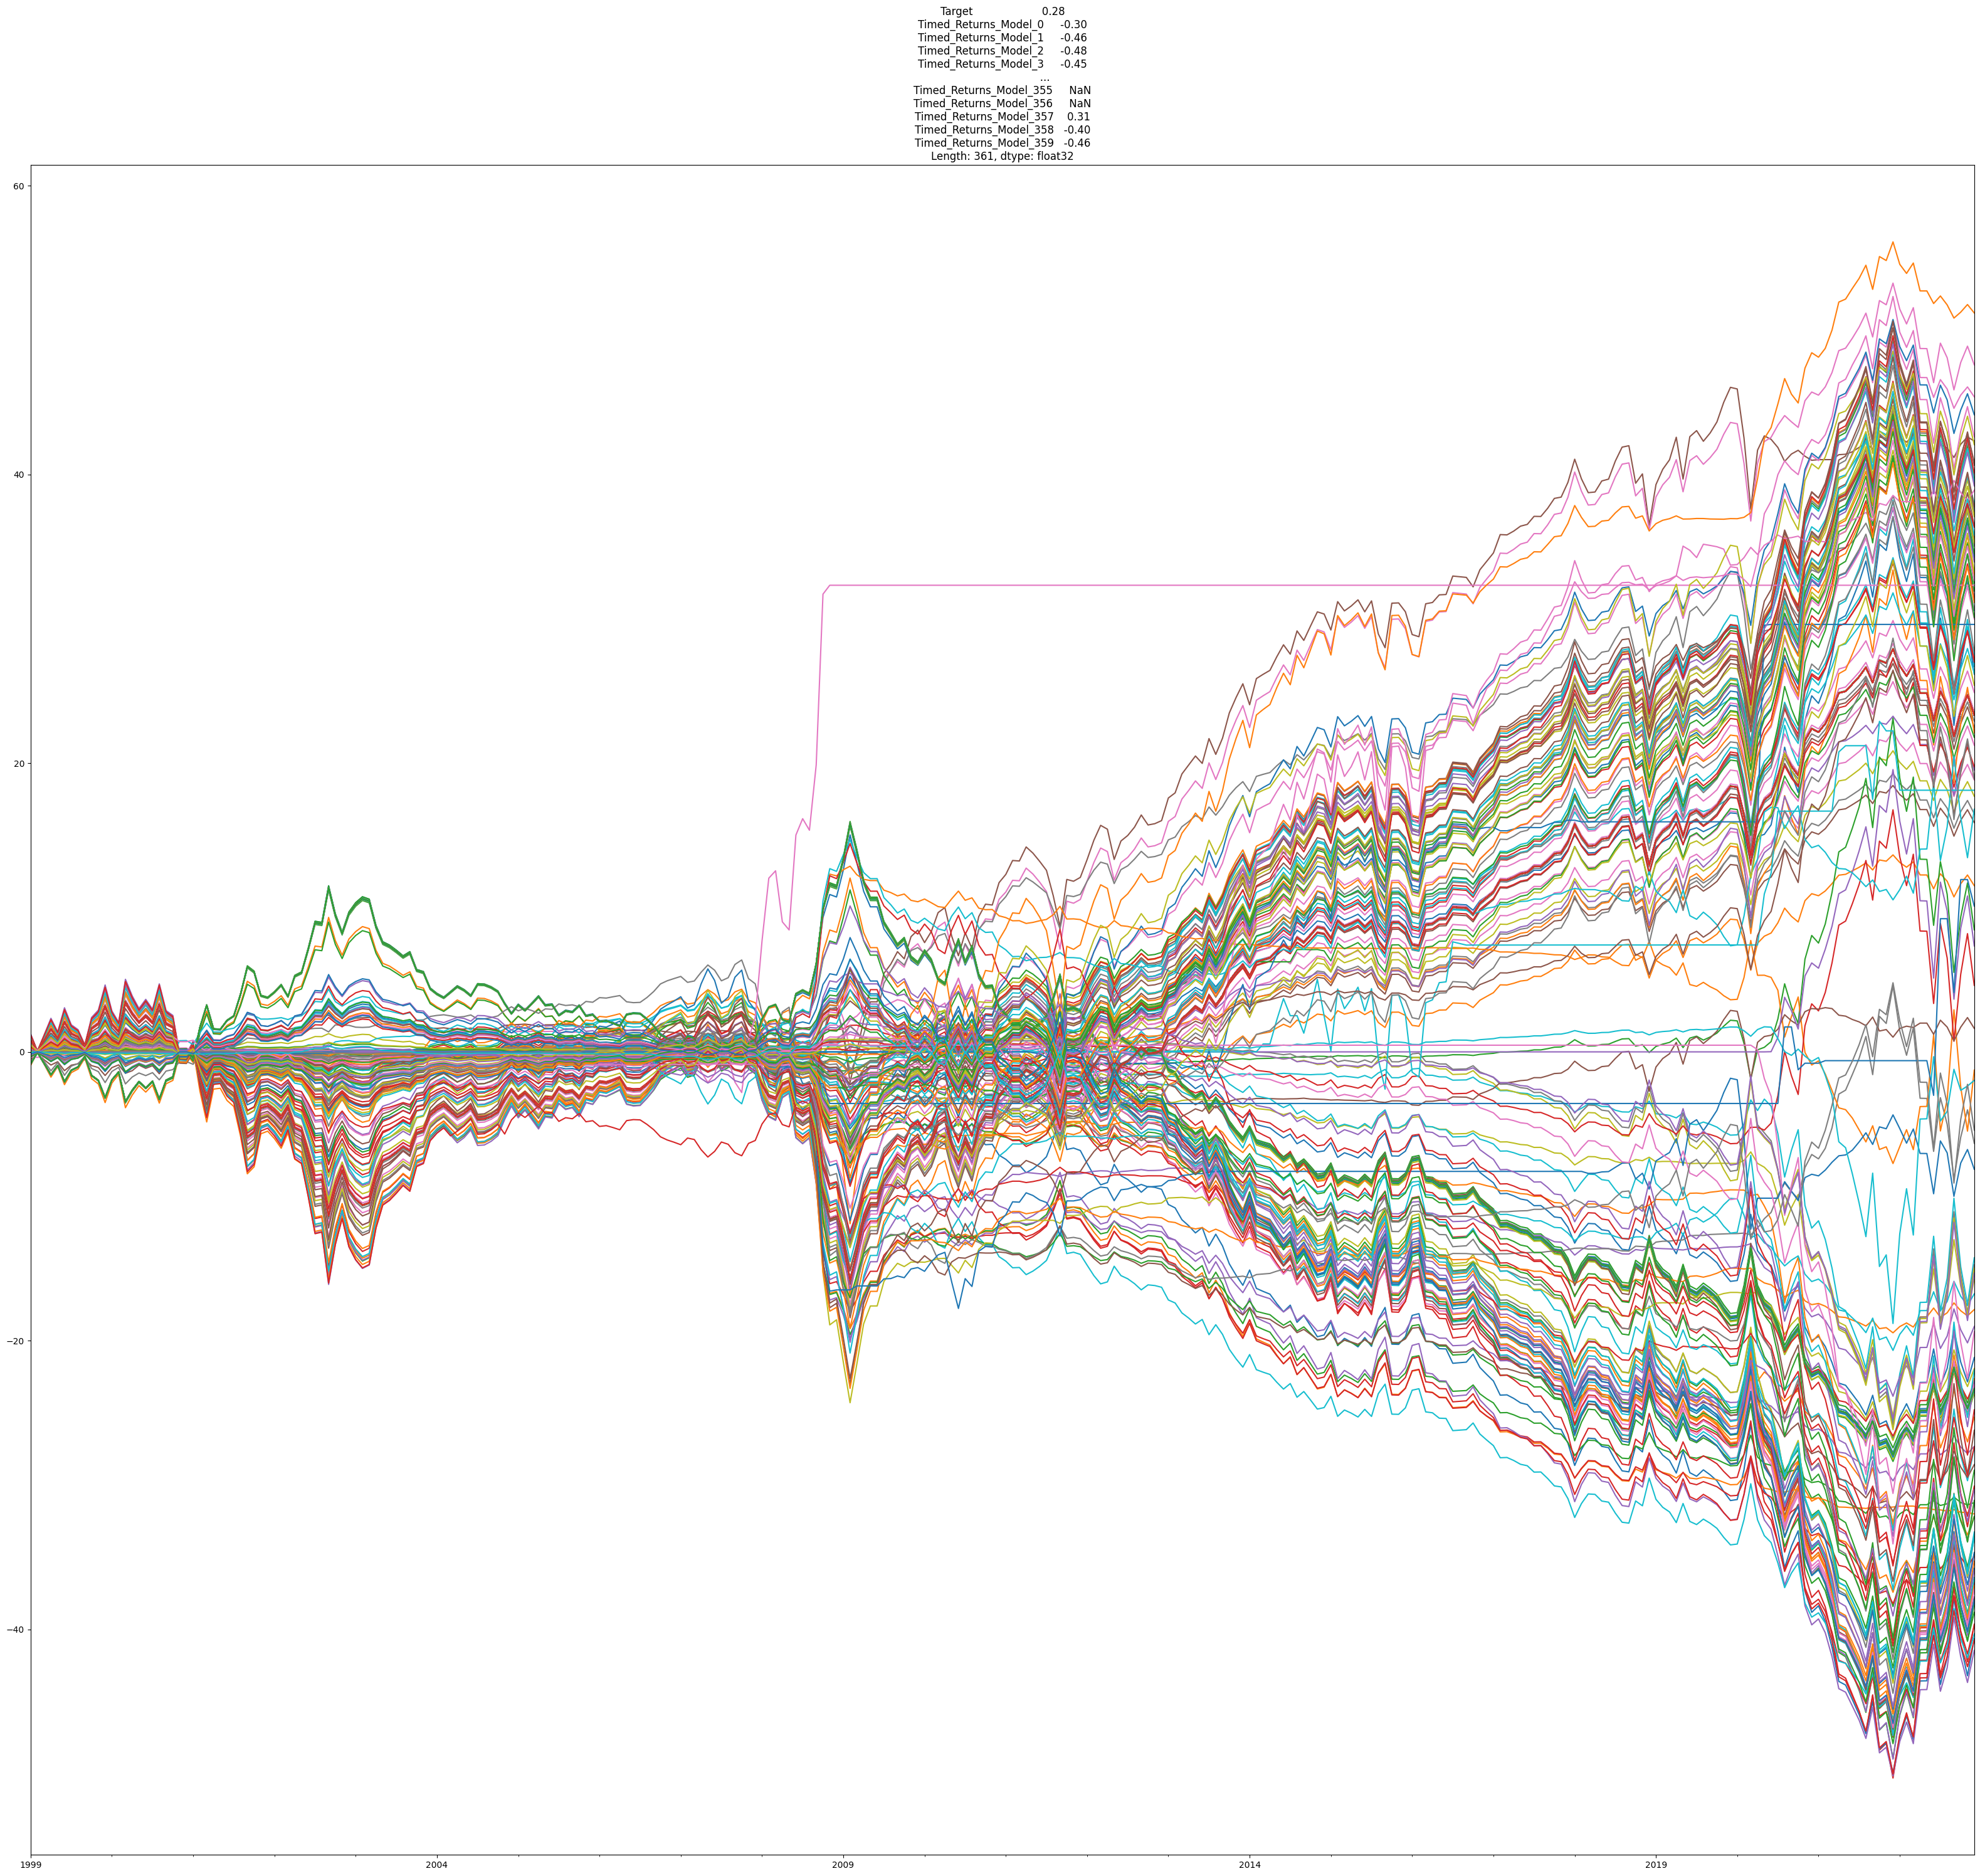

In [ ]:
# Update to back out predictions using 'model specs'
train_sample = [get_predictions(train_loader, model_specs[id]['model']) for id in model_specs]
test_sample = [get_predictions(test_loader, model_specs[id]['model']) for id in model_specs]
train_targets = train_sample[0][0]

#
train_predictions = np.concatenate([train_sample[id][1].reshape(-1, 1) for id in range(model_idx)], axis=1).mean(1) #on fait la moyenne de chaque seed

test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[id][1].reshape(-1, 1) for id in range(model_idx)], axis=1)


# Calculer les retours temporels pour chaque modèle
timed_returns_per_model = test_targets.reshape(-1, 1) * all_test_predictions

# Créer un DataFrame pour chaque retour temporel et la cible de test
columns = ['Target'] + [f'Timed_Returns_Model_{i}' for i in range(model_idx)]
together_per_model = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns_per_model], axis=1),
                                  columns=columns, index=test_dates)

# Normaliser et tracer les résultats cumulatifs pour visualiser
normalized = (together_per_model / together_per_model.std()).cumsum()
normalized.plot(figsize=(40, 35), legend=None)

plt.title(f'{FredAndGoyalData.sharpe_ratio(together_per_model)}')
plt.show()


Below are some ideas to present our results. It allows us to observe what values of the hyperparemeters lead to the best performances. We finally compute mean sharpe ratios to get a great overview of the results.

In [ ]:
for id in model_specs:
  model_specs[id]['sharpe_ratio'] = FredAndGoyalData.sharpe_ratio(together_per_model[f'Timed_Returns_Model_{id}'])
df_model_specs = pd.DataFrame.from_dict(model_specs, orient='index') #DF récap de tout les NN


We decided to have our models rank like this so it is very easy to manipulate as we have all models and their specification and every architecture can be taken appart and analyzed.

In [ ]:
df_model_specs

model       lr  depth  \
0    FlexibleMLP(\n  (layers): ModuleList(\n    (0)...   0.0001      1   
1    FlexibleMLP(\n  (layers): ModuleList(\n    (0)...   0.0001      1   
2    FlexibleMLP(\n  (layers): ModuleList(\n    (0)...   0.0001      1   
3    FlexibleMLP(\n  (layers): ModuleList(\n    (0)...   0.0001      1   
4    FlexibleMLP(\n  (layers): ModuleList(\n    (0)...   0.0001      1   
..                                                 ...      ...    ...   
355  FlexibleMLP(\n  (layers): ModuleList(\n    (0)...  10.0000     10   
356  FlexibleMLP(\n  (layers): ModuleList(\n    (0)...  10.0000     10   
357  FlexibleMLP(\n  (layers): ModuleList(\n    (0)...  10.0000     10   
358  FlexibleMLP(\n  (layers): ModuleList(\n    (0)...  10.0000     10   
359  FlexibleMLP(\n  (layers): ModuleList(\n    (0)...  10.0000     10   

       decay  sharpe_ratio  
0     0.0001         -0.30  
1     0.0010         -0.46  
2     0.0100         -0.48  
3     0.1000         -0.45  
4     1.0000          0.51  
..       ...           ...  
355   0.0010           NaN  
356   0.0100           NaN  
357   0.1000          0.31  
358   1.0000         -0.40  
359  10.0000         -0.46  

[360 rows x 5 columns]

Finally, we can observe the variation in sharpe ratio depending on the combination. We can observe that this is not a rule of thumb as there is no real specific pattern.
Even in the mean average below we don't really observe clear patterns.

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=df_model_specs['lr'],  # Learning Rate sur l'axe X
    y=df_model_specs['depth'],  # Depth sur l'axe Y
    z=df_model_specs['decay'],  # Decay sur l'axe Z
    mode='markers',
    marker=dict(
        size=5,
        color=df_model_specs['sharpe_ratio'],  # Utiliser le Sharpe Ratio comme couleur
        colorscale='Reds',  # Échelle de couleur
        colorbar=dict(title='Sharpe Ratio'),  # Légende de couleur
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Learning Rate', type='log', autorange=True),
        yaxis=dict(title='Depth', autorange=True),
        zaxis=dict(title='Decay', type='log', autorange=True),
    )
)


fig.show()

In [ ]:
mean_sharpe_by_depth = df_model_specs.groupby('depth')['sharpe_ratio'].mean().round(2)
mean_sharpe_by_depth.name = 'Average Sharpe Ratio'
mean_sharpe_by_depth

depth
1     0.03
2     0.09
3     0.02
4     0.07
5     0.16
6     0.12
7     0.26
8     0.20
9     0.16
10    0.14
Name: Average Sharpe Ratio, dtype: float64

In [ ]:
mean_sharpe_by_lr = df_model_specs.groupby('lr')['sharpe_ratio'].mean().round(2)
mean_sharpe_by_lr.name = 'Average Sharpe Ratio'
mean_sharpe_by_lr


lr
0.0001     0.01
0.0010     0.20
0.0100     0.19
0.1000     0.22
1.0000     0.09
10.0000    0.04
Name: Average Sharpe Ratio, dtype: float64

In [ ]:
mean_sharpe_by_decay = df_model_specs.groupby('decay')['sharpe_ratio'].mean().round(2)
mean_sharpe_by_decay.name = 'Average Sharpe Ratio'
mean_sharpe_by_decay

decay
0.0001     0.08
0.0010     0.14
0.0100     0.14
0.1000     0.15
1.0000     0.12
10.0000    0.12
Name: Average Sharpe Ratio, dtype: float64

Conclusion:
- Depth has a significant effect on the sharpe ratio of timed returns. There is a positive relation between the number of layer and the sharpe.
- The learning rate has a huge effect on the sharpe ratio of the strategies. It must be kept between 0.001 and 0.1
- The decay has the less significant impact on sharpes. However it shouldn't be too low and the it seems to be the most performant when it's 0.1